# RandomForest Regressor with reduced feature space
- WGCNA was used to cluster the transcription data
- account for multicolinearity

In [9]:
from sklearn.model_selection import cross_val_score, LeaveOneOut
from sklearn.preprocessing import StandardScaler as zscore # zscore
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Lasso #LRlasso
from collections import OrderedDict
from joblib import dump, load #to save models in files
from sklearn.model_selection import KFold
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import re
import json
import os
from datetime import datetime
import sys



In [2]:
from sklearn.model_selection import GridSearchCV
def gridcv(X, y, model, param_grid, naimpute=False, prepy=True, scorer = 'neg_mean_squared_error', cv_meth = LeaveOneOut(), cv_n_jobs = 1):
    """
    Perform Cross-Validation (defaukt: LOOCV) with hyperparameter tuning using GridSearchCV.
    
    Parameters:
    ----------
    X : pandas DataFrame or numpy array
        The feature matrix.
        
    y : pandas Series or numpy array
        The target variable.
        
    model : scikit-learn estimator
        The machine learning model to be used, should be an uninitialized model instance 
        (e.g., Lasso(), not Lasso(alpha=1.0)).
        
    param_grid : dict
        Dictionary containing the hyperparameters to be tuned and their possible values. 
        The keys should be prefixed with 'regressor__' to work with the pipeline.
        
    naimpute : bool, optional (default=False)
        Toggle imputation for missing values. 
        Currently not implemented; will print a message and return 0 if set to True.
        
    prepy : bool, optional (default=True)
        Toggle preprocessing target variable 'y' by setting any negative values to zero.
        
    scorer : str, callable, or None, optional (default='neg_mean_squared_error')
        A string or a scorer callable object / function with signature scorer(estimator, X, y). 
        For valid scoring strings, see the scikit-learn documentation.
        
    cv_meth : cross-validation generator, optional (default=LeaveOneOut())
        A cross-validation splitting strategy. 
        Possible inputs for cv are integers to specify the number of folds in a (Stratified)KFold, 
        CV splitter, cross-validation generator iterators, or an iterable.
        
    Returns:
    -------
    overall_metric : dict
        Dictionary containing the overall metrics and other details from the GridSearchCV.
        
    out_model : GridSearchCV object
        Fitted GridSearchCV object.
        
    best_params : dict
        Dictionary containing the best hyperparameters found by GridSearchCV.

    Call:
    ------
    from sklearn.model_selection import KFold

    # set up KFold cross-validator
    kfold_cv = KFold(n_splits=3, shuffle=True, random_state=42)

    param_grid = {
        'regressor__alpha': np.array(np.arange(0.0125, 0.0425, 0.0025)),
        'regressor__fit_intercept': [True, False]
    }
    print(param_grid)

    # Call the gridcv function with KFold as the cross-validation method
    lasso_fullkfold_scores, lasso_fullkfold_model, best_param = gridcv(
        X, 
        y,
        Lasso(max_iter=4000),
        param_grid,
        scorer='r2', 
        cv_meth=kfold_cv
    )
    dump(lasso_fullkfold_model, './models/lasso_fullkfold_model.pkl') # save the model as .pkl
    """

    # overall_metric = {'CV': cv_meth, 'scoring_metric': scorer} originally
    overall_metric = {'CV': str(cv_meth), 'scoring_metric': str(scorer)} # transformed to string because json dump scores later

    if prepy:
        y[y < 0] = 0
    
    if naimpute:
      print("not implemented")
      return 0


    pipeline = Pipeline([
        ('scaler', zscore()), 
        ('regressor', model)        # Regression model
    ])

    
    # declaring an Grid object
    # score : https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter
    out_model = GridSearchCV(pipeline, param_grid=param_grid, cv=cv_meth, scoring=scorer, n_jobs=cv_n_jobs).fit(X,y)
    # GridSearchCV need the regressor__ prefix for the pipiline object in the para_grid later when called

    best_pipeline = out_model.best_estimator_
    y_pred = best_pipeline.predict(X)

    overall_metric['correlation_true_pred'] = list(np.corrcoef(list(y), list(y_pred)))
    overall_metric['correlation_true_pred'][0] = list(overall_metric['correlation_true_pred'][0])
    overall_metric['correlation_true_pred'][1] = list(overall_metric['correlation_true_pred'][1])


    # LOOCV folds: split{i}_test_score (number of data points minus one) 
    overall_metric['fold_scores'] = [out_model.cv_results_[f'split{i}_test_score'][out_model.best_index_] for i in range(out_model.n_splits_)]
    best_params = out_model.best_params_


    # printing section
    print("best parameter from gridsearch>>\n", out_model.best_params_)
    print(overall_metric['CV'])
    print(overall_metric['scoring_metric'])
    print("correlation Matrix>>\n", overall_metric['correlation_true_pred'])
    print("scores for each fold>>\n",overall_metric['fold_scores'])

    if str(model).startswith("Lasso"):
        # access the 'regressor' step from the best pipeline and then its coefficients
        coefficients = best_pipeline.named_steps['regressor'].coef_
        overall_metric['non_zero_coefficients'] = coefficients[coefficients != 0]
        overall_metric['non_zero_coefficients'] = overall_metric['non_zero_coefficients'].tolist()
        overall_metric['non_zero_features'] = list(X.columns[np.where(coefficients != 0)[0]])
        print("non_zero_features>>\n",overall_metric['non_zero_features'])

    if str(model).startswith("RandomForestRegressor"):
        pass
        print("<<gridcv done>>")
        #feature_names = X.columns
        #feature_importances = best_pipeline.named_steps['regressor'].feature_importances_
        #feature_importance_dict = dict(zip(feature_names, feature_importances))
        #sorted_feature_importance = sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)
        #overall_metric['feature_importances'] = OrderedDict(sorted_feature_importance)
        #print("feature_importances>>\n",overall_metric['feature_importances'])
       

    return overall_metric, out_model, best_params



In [3]:

def convert_type(obj):
    """
    Converts an type of numpy into a python inherent type
    This function can be used in combination with json.dump:
    ----
    Usage Example:
    
    with open(f"{output_path}{output_prefix}_nXcv.json", 'w') as file:
       json.dump(cv_results, file, default=convert_type)
    """
    if isinstance(obj, np.integer):
        return int(obj)
    elif isinstance(obj, np.floating):
        return float(obj)
    elif isinstance(obj, np.ndarray):
        return obj.tolist()
    else:
        return obj



In [4]:

# In[41]:


def nX_cross_validation(X, target, param_grid, scorer_estimate, output_prefix, random_states, output_path='./models/10xKfold/', n_splits=3, cv_n_jobs=1, regr_n_job=1):
    if os.path.exists(output_path):
        print(f"The path {output_path} exists.")
    else:
        print(f"The path {output_path} does not exist.")
        raise FileNotFoundError(f"The path {output_path} does not exist.")
    best_fold_mean = float('-inf')
    best_model = []

    #cv_results = {'random_state': [], 'scores': {}, 'mean_scores': [], 'selected_features': {}, 'common_features': {}, 'model': {}}
    cv_results = {'random_state': [], 'scores': {}, 'mean_scores': [], 'selected_features': {}, 'best_param': []}

    for ran_state in random_states:
        print(ran_state)
        kfold_cv = KFold(n_splits=n_splits, shuffle=True, random_state=ran_state)
        scores, model, best_param = gridcv(
            X, 
            target,
            RandomForestRegressor(n_jobs=regr_n_job),
            param_grid,
            prepy=False,
            scorer=scorer_estimate, 
            cv_meth=kfold_cv,
            cv_n_jobs=cv_n_jobs
        )
        cv_results['random_state'].append(ran_state)
        cv_results['scores'][ran_state] = scores
        cv_results['mean_scores'].append(np.mean(scores['fold_scores']))
        if best_fold_mean < np.mean(scores['fold_scores']):
            best_fold_mean = np.mean(scores['fold_scores'])
            cv_results['best_param'] = best_param, ran_state, np.mean(scores['fold_scores'])

    # REF 1

    print(f"best estimator>>\n found in split: {cv_results['best_param'][1]}\n param_grid: {cv_results['best_param'][0]}\n mean fold score {cv_results['best_param'][2]}")    
    regr = RandomForestRegressor(max_features=cv_results['best_param'][0]['regressor__max_features'], n_estimators=cv_results['best_param'][0]['regressor__n_estimators'], bootstrap=cv_results['best_param'][0]['regressor__bootstrap'], n_jobs=regr_n_job)
    best_model = regr.fit(X, target)
    feature_names = X.columns
    feature_importances = best_model.feature_importances_
    feature_importance_dict = dict(zip(feature_names, feature_importances))
    sorted_feature_importance = sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)
    sorted_feature_importance = OrderedDict(sorted_feature_importance)
    # select feature based on cumulative importance
    cumulative_importance = 0.0
    selected_features = []
    for feature, importance in sorted_feature_importance.items():
        #print(f"feaute, {feature},  import, {importance}")
        cumulative_importance += importance
        selected_features.append(feature)
        if cumulative_importance >= 0.95:
            break
    cv_results['selected_features'] = selected_features

    #save to json
    with open(f"{output_path}{output_prefix}_nXcv.json", 'w') as file:
       json.dump(cv_results, file, default=convert_type)
    file.close()
    
    return cv_results



In [5]:

def to_valid_variable_name(name):
    # Replace special characters with underscores
    name = re.sub(r'\W|^(?=\d)', '_', name)
    # Reduce multiple consecutive underscores to one
    name = re.sub(r'_{2,}', '_', name)
    # Truncate length if necessary
    max_length = 30
    if len(name) > max_length:
        name = name[:max_length]
    # Ensure it doesn't start with a number
    if name[0].isdigit():
        name = "_" + name
    return name



In [8]:
gcms_mut = pd.read_csv("/home/t44p/PW_rawdata/tr_gc_mutual/gcms_mut.csv", sep=",")
lcms_mut = pd.read_csv("/home/t44p/PW_rawdata/tr_gc_mutual/lcms_mut.csv", sep=",")
#gcms_mut = pd.read_csv("/work/yhesse/PW_rawdata/tr_gc_mutual/gcms_mut.csv", sep=",")
#lcms_mut = pd.read_csv("/work/yhesse/PW_rawdata/tr_gc_mutual/lcms_mut.csv", sep=",")



In [7]:
#X = pd.read_csv("/work/yhesse/PW_rawdata/tr_gc_mutual/tr_wgcna_MEs.csv", sep=",", index_col=0)
X = pd.read_csv("/home/t44p/PW_rawdata/tr_gc_mutual/tr_wgcna_MEs.csv", sep=",", index_col=0)

X.head()


,MEdarkred,MEsalmon,MEsienna,MEdarkgrey,MEchocolate,MElightsalmon,MErosybrown,MEred,MEsaddlebrown,MEblack,MEmaroon,MEtomato,MEperu,MElinen,MEorangered,MEmistyrose,MEdimgrey,MEseashell
ref,,,,,,,,,,,,,,,,,,
Xe_De_R2_T00,-0.070542,-0.076521,-0.036572,0.273065,-0.063839,0.104769,-0.069150,-0.026775,0.142589,-0.095037,-0.025330,0.155800,0.087210,0.335986,0.072189,-0.121119,-0.098802,-0.143420
Xe_De_R2_T03,0.660550,0.047808,-0.036807,0.017875,0.000776,0.033626,0.122773,0.050396,0.269496,0.099744,-0.033325,0.074530,-0.039596,-0.040912,-0.194549,-0.011116,-0.168250,-0.127068
Xe_De_R2_T06,0.135545,0.240469,0.044559,0.038486,0.337999,0.101275,0.353547,0.583660,0.233476,0.204601,0.083258,-0.067397,-0.371903,-0.414662,-0.220544,-0.043053,-0.138183,-0.177591
Xe_De_R2_T09,-0.010512,0.006573,-0.030147,-0.068341,0.128373,0.098445,0.256827,0.139581,0.075497,0.019816,0.178133,0.111921,-0.104833,-0.068798,0.036791,-0.034521,-0.146483,-0.129996
Xe_De_R2_T12,0.029663,0.192380,-0.222354,-0.147784,-0.191662,-0.138411,-0.049868,-0.013878,-0.033662,-0.055919,0.091908,0.196573,-0.093520,-0.077363,0.015746,0.421891,-0.109746,0.176336


In [10]:
X.describe()

,MEdarkred,MEsalmon,MEsienna,MEdarkgrey,MEchocolate,MElightsalmon,MErosybrown,MEred,MEsaddlebrown,MEblack,MEmaroon,MEtomato,MEperu,MElinen,MEorangered,MEmistyrose,MEdimgrey,MEseashell
count,4.000000e+01,4.000000e+01,4.000000e+01,4.000000e+01,40.000000,4.000000e+01,4.000000e+01,4.000000e+01,4.000000e+01,4.000000e+01,4.000000e+01,4.000000e+01,4.000000e+01,4.000000e+01,4.000000e+01,4.000000e+01,4.000000e+01,4.000000e+01
mean,1.387779e-17,8.326673e-18,-4.857226e-18,2.220446e-17,0.000000,1.387779e-18,1.942890e-17,-5.898060e-18,3.191891e-17,6.938894e-18,2.498002e-17,-3.330669e-17,-4.371503e-17,-5.551115e-18,2.220446e-17,1.804112e-17,-4.857226e-18,5.551115e-18
std,1.601282e-01,1.601282e-01,1.601282e-01,1.601282e-01,0.160128,1.601282e-01,1.601282e-01,1.601282e-01,1.601282e-01,1.601282e-01,1.601282e-01,1.601282e-01,1.601282e-01,1.601282e-01,1.601282e-01,1.601282e-01,1.601282e-01,1.601282e-01
min,-1.138300e-01,-2.600550e-01,-2.365588e-01,-1.477839e-01,-0.209157,-2.081593e-01,-1.675048e-01,-1.492057e-01,-1.707689e-01,-1.163433e-01,-2.496120e-01,-2.652702e-01,-3.719028e-01,-4.146624e-01,-2.657593e-01,-1.643718e-01,-1.846908e-01,-2.313994e-01
25%,-8.010000e-02,-1.277758e-01,-1.450957e-01,-7.794776e-02,-0.165584,-1.545608e-01,-1.235165e-01,-1.269882e-01,-1.384274e-01,-7.997767e-02,-1.500174e-01,-1.338501e-01,-8.820542e-02,-7.676547e-02,-1.079258e-01,-1.212455e-01,-1.226649e-01,-1.396901e-01
50%,-5.127660e-02,-3.853315e-02,-4.099181e-03,-4.851511e-02,0.011647,-1.800656e-02,-4.234303e-02,-3.101219e-02,-5.438014e-02,-5.004428e-02,2.824957e-03,3.987692e-02,3.040211e-03,-1.426004e-02,-3.137595e-02,-4.844974e-02,-7.930925e-02,-7.528562e-02
75%,9.456645e-03,1.334349e-01,1.232505e-01,1.888977e-02,0.113082,1.206793e-01,3.152694e-02,6.340209e-02,1.356248e-01,2.781377e-02,9.793473e-02,1.143999e-01,1.387606e-01,9.291947e-02,8.169030e-02,7.409209e-02,1.351233e-01,1.567136e-01
max,6.605497e-01,3.721467e-01,3.176386e-01,6.464087e-01,0.341945,3.023816e-01,4.609460e-01,5.836597e-01,3.629370e-01,8.725710e-01,3.102658e-01,2.888801e-01,2.838200e-01,3.573486e-01,4.009637e-01,4.218911e-01,3.731072e-01,2.550031e-01


In [9]:
gcms_target_dict = {}
for target in gcms_mut['metabolite']:
    o = to_valid_variable_name(target)
    #print(f"{o} == \t {target}")
    gcms_target_dict[o] = str(target)


lcms_target_dict = {}
for target in lcms_mut['metabolite']:
    o = to_valid_variable_name(target)
    #print(f"{o} == \t {target}")
    lcms_target_dict[o] = str(target)
        

In [13]:
#np.round(np.exp2(np.array(np.arange(3.2, 13.3, 2)))).astype(int)
#np.arange(2, 7, 1)
#np.array(np.arange(100, 600, 100))

array([100, 200, 300, 400, 500])

In [14]:
tenX = [42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52]
#tenX = [42, 43 ]
cvcpu = 4
rgrcpu = 4
param_grid = {
    'regressor__n_estimators': np.array(np.arange(100, 600, 100)),
    'regressor__max_features': np.arange(2, 7, 1),
    'regressor__bootstrap': [True, False]
}   

#print(f"param_grid >>> {param_grid}")


param_grid >>> {'regressor__n_estimators': array([100, 200, 300, 400, 500]), 'regressor__max_features': array([2, 3, 4, 5, 6]), 'regressor__bootstrap': [True, False]}


In [28]:

out = '/work/yhesse/jobs/xele_ml/newfeat_rfr/gcms/'

print(f"param_grid >>> {param_grid}")
for i, (gcms_target, orig_str) in enumerate(gcms_target_dict.items()):
    now = datetime.now()
    print(f"\n>> START {gcms_target} {now.isoformat()} <<")
    tmp_10xKfold = nX_cross_validation(X.iloc[:,:], gcms_mut.iloc[i,1:], param_grid, 'r2', str(gcms_target), random_states=tenX, output_path=out, cv_n_jobs=cvcpu, regr_n_job=rgrcpu)
    print(f"\n>> DONE <<\n\n")
 

with open(f"{out}gcms_dict_nXcv.json", 'w') as file:
    json.dump(gcms_target_dict, file)




param_grid >>> {'regressor__n_estimators': array([ 500,  700,  900, 1100, 1300, 1500]), 'regressor__max_features': array([ 1,  4,  7, 10, 13, 16, 19]), 'regressor__bootstrap': [True, False]}

>> START _6_phospho_gluconate 2024-01-23T13:21:22.604404 <<
The path /work/yhesse/jobs/xele_ml/newfeat_rfr/gcms/ exists.
42
best parameter from gridsearch>>
 {'regressor__bootstrap': False, 'regressor__max_features': 1, 'regressor__n_estimators': 700}
KFold(n_splits=3, random_state=42, shuffle=True)
r2
correlation Matrix>>
 [[1.0, 1.0], [1.0, 1.0]]
scores for each fold>>
 [0.5614964686760607, 0.4372332883930834, 0.7733293292756453]
<<gridcv done>>
43


KeyboardInterrupt: 

In [ ]:
out = '/work/yhesse/jobs/xele_ml/newfeat_rfr/lcms/'

for i, (lcms_target, orig_str) in enumerate(lcms_target_dict.items()):
    now = datetime.now()
    print(f"\n>> START {lcms_target} {now.isoformat()} <<")
    tmp_10xKfold = nX_cross_validation(X.iloc[:,:], lcms_mut.iloc[i,1:], param_grid, 'r2', str(lcms_target), random_states=tenX, output_path=out, cv_n_jobs=5, regr_n_job=5)
    print(f"\n>> DONE <<\n\n")
 

with open(f"{out}lcms_dict_nXcv.json", 'w') as file:
    json.dump(lcms_target_dict, file)



# Reading score data

In [27]:

path_gc = "/home/t44p/PW_rawdata/results/newfeat_rfr/gcms/"
path_lc ="/home/t44p/PW_rawdata/results/newfeat_rfr/lcms/"

rfr_results = {}


# Iterate over each file in the directory
for p in [path_gc, path_lc]:

    for file in os.listdir(p):
        if file.endswith(".json") and not(file.startswith('gcms_dict_nXcv') or file.startswith('lcms_dict_nXcv')):
            file_path = os.path.join(p, file)
            with open(file_path, 'r') as json_file:
                data = json.load(json_file)
            
            # Extract mean scores and fold scores
            print(file)
            
                
            all_means = data['mean_scores']
            all_fold_scores = []
            for item, values in data['scores'].items():
                all_fold_scores.extend(values['fold_scores'])

            # Use file name without extension as the key
            file_name = os.path.splitext(file)[0]
            rfr_results[file_name] = {
                'all_mean_scores': all_means,
                'mean_10x': np.mean(all_means),
                'all_fold_scores': all_fold_scores,
                'best_param': data['best_param']
            }

len(rfr_results.keys())

Cellobiose_361_204_rt14_40_nXcv.json
tyrosine_218_280_rt10_78_nXcv.json
threonic_acid_292_220_rt7_49_nXcv.json
isoleucin_158_233_rt_5_21_nXcv.json
asparagine_116_188_rt9_00_nXcv.json
adenine_264_279_rt11_12_nXcv.json
glycerol_117_205_rt4_75_nXcv.json
raffinose_437_451_rt16_91_nXcv.json
adenosine_5_monophosphate_169__nXcv.json
ornithine_142_174_rt9_34_nXcv.json
glucose_160_rt9_81_nXcv.json
inositol_myo_305_265_rt10_71_nXcv.json
phosphoric_acid_314_299_rt_5_4_nXcv.json
sucrose_437_361_rt13_77_nXcv.json
hexose_307_217_rt9_58_nXcv.json
alanine_3_cyano_141_100_rt6_78_nXcv.json
threonine_219_291_rt6_01_nXcv.json
tryptophan_202_291_rt12_94_nXcv.json
citric_acid_273_375_rt9_72_nXcv.json
alanine_116_218_rt3_38_nXcv.json
glucose_1_phosphate_217_rt9_16_nXcv.json
leucine_158_232_rt4_97_nXcv.json
trehalose_alpha_alpha_191_169__nXcv.json
quinic_acid_255_345_rt9_45_nXcv.json
Oxalic_acid_219_147_3_94_nXcv.json
valine_144_218_rt4_42_nXcv.json
dopamine_174_426_rt11_11_nXcv.json
galactinol_204_191_rt15_3

243

In [28]:
param_grid = {
    'regressor__n_estimators': np.array(np.arange(100, 600, 100)),
    'regressor__max_features': np.arange(2, 7, 1),
    'regressor__bootstrap': [True, False]
}   

print(f"parameter grid >>\n {param_grid}")

rfr_results['Cellobiose_361_204_rt14_40_nXcv']
for key in rfr_results.keys():
    print(f"{rfr_results[key]['mean_10x']}\t{rfr_results[key]['best_param']}")

parameter grid >>
 {'regressor__n_estimators': array([100, 200, 300, 400, 500]), 'regressor__max_features': array([2, 3, 4, 5, 6]), 'regressor__bootstrap': [True, False]}
0.5897269085803033	[{'regressor__bootstrap': False, 'regressor__max_features': 3, 'regressor__n_estimators': 100}, 51, 0.6749869469060888]
0.11085437329313494	[{'regressor__bootstrap': False, 'regressor__max_features': 5, 'regressor__n_estimators': 100}, 43, 0.3470700034966161]
0.7318115388637707	[{'regressor__bootstrap': False, 'regressor__max_features': 2, 'regressor__n_estimators': 200}, 50, 0.8173995342243335]
0.2121212925727157	[{'regressor__bootstrap': True, 'regressor__max_features': 6, 'regressor__n_estimators': 200}, 49, 0.4095664624591115]
-0.22458430606075327	[{'regressor__bootstrap': True, 'regressor__max_features': 6, 'regressor__n_estimators': 100}, 43, -0.02990339837679164]
-0.2655481852980244	[{'regressor__bootstrap': True, 'regressor__max_features': 6, 'regressor__n_estimators': 300}, 49, -0.057441038

In [29]:
variances = [np.var(target_data['all_fold_scores']) for target_data in rfr_results.values()]
c = 0
print(max(variances))
print(f"target\t score variance across 10 runs\t min score\tmax score")
for item, target_data in rfr_results.items():
    np.var(target_data['all_fold_scores'])
    if np.var(target_data['all_fold_scores']) > 2:
        print(f"{item}\t{np.var(target_data['all_fold_scores'])}\t{min(target_data['all_fold_scores'])}\t{max(target_data['all_fold_scores'])} ")# {max(target_data['all_fold_scores'])}
        c += 1
print(c)

96.26583578128012
target	 score variance across 10 runs	 min score	max score
Dehydro_Ascorbic_acid_L_nXcv	3.329306157698497	-5.890785389865212	-0.05049764868275086 
_D_Glycero_alpha_D_Manno_Hepto_nXcv	3.0330107023987636	-10.205282235286651	0.17263555093521077 
Triterpene_8_14_nXcv	96.26583578128012	-57.52374975704539	0.13599824118107962 
3


### plot all variances

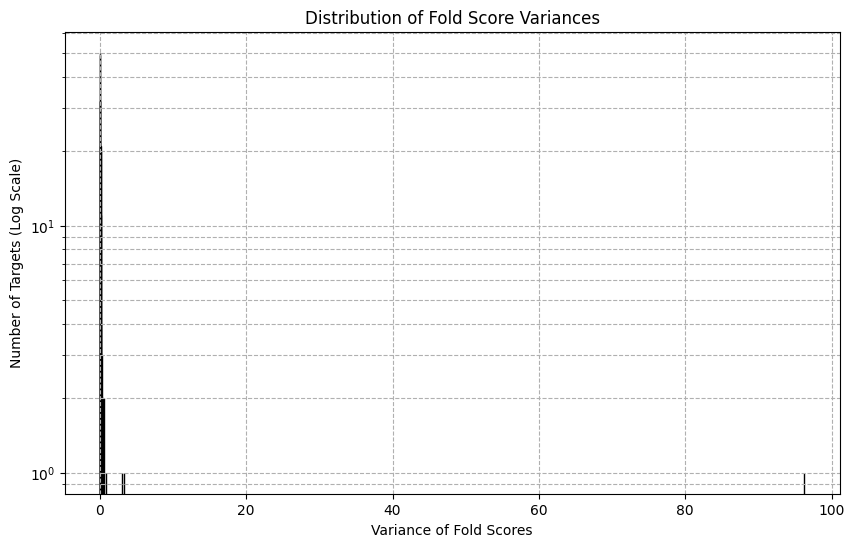

In [30]:
# Calculate the variances of fold scores for each target
variances = [np.var(target_data['all_fold_scores']) for target_data in rfr_results.values()]

# Since we have variances that are very high, we will use a logarithmic scale on the y-axis.
# We also use a wider range of bins to capture the high variance values.

# Find the maximum variance to define the end of the bin range
max_variance = max(variances)

# Define the number of bins or use 'auto' for automatic binning
num_bins = 'auto'  # You can also specify an integer for a fixed number of bins

# Plotting the histogram
plt.figure(figsize=(10, 6))
plt.hist(variances, bins=num_bins, edgecolor='black', log=True)  # Note the log=True parameter
plt.title('Distribution of Fold Score Variances')
plt.xlabel('Variance of Fold Scores')
plt.ylabel('Number of Targets (Log Scale)')
plt.grid(True, which="both", ls="--")  # Grid for both major and minor ticks
plt.show()

### exlude the variance > 2 by binning

bins [0.   0.05 0.1  0.15 0.2  0.25 0.3  0.35 0.4  0.45 0.5  0.55 0.6  0.65
 0.7  0.75 0.8  0.85 0.9  0.95 1.   1.05 1.1  1.15 1.2  1.25 1.3  1.35
 1.4  1.45 1.5  1.55 1.6  1.65 1.7  1.75 1.8  1.85 1.9  1.95 2.  ], average bin size 0.05


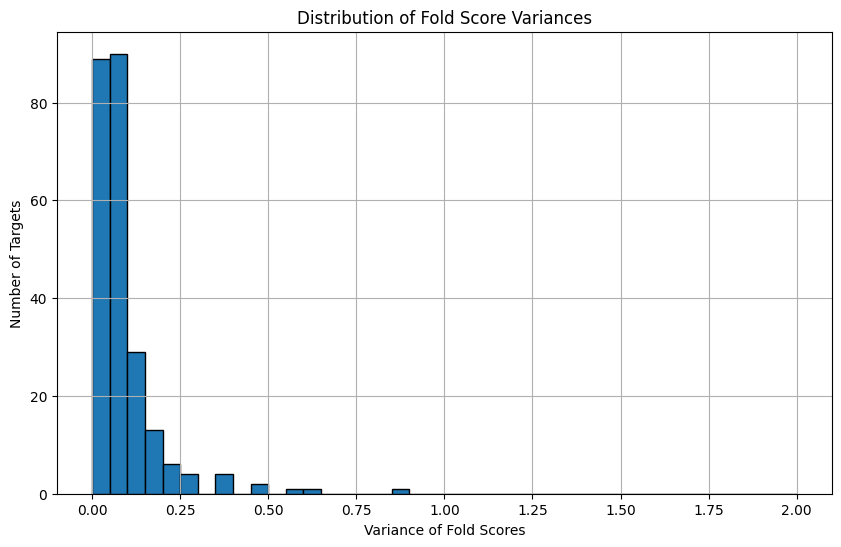

In [31]:
# Plotting the histogram
plt.figure(figsize=(10, 6))
bins=np.arange(0, 2.05, 0.05)
bin_sizes = np.diff(bins)
print(f"bins {bins}, average bin size {np.mean(bin_sizes)}")
plt.hist(variances, bins=bins, edgecolor='black')
plt.title('Distribution of Fold Score Variances')
plt.xlabel('Variance of Fold Scores')
plt.ylabel('Number of Targets')
plt.grid(True)
plt.show()


Bin sizes: [0.17191529 0.17191529 0.17191529 0.17191529 0.17191529 0.17191529
 0.17191529 0.17191529 0.17191529 0.17191529 0.17191529 0.17191529
 0.17191529 0.17191529 0.17191529 0.17191529 0.17191529 0.17191529
 0.17191529 0.17191529 0.17191529 0.17191529]
Average bin size: 0.17191529073643078


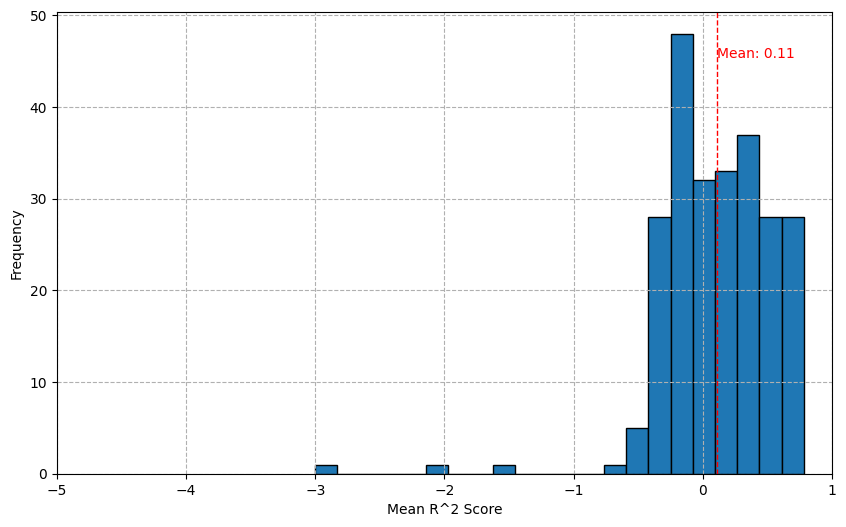

In [32]:
plt.figure(figsize=(10, 6))

all_mean_scores = [rfr_results[target_data]['mean_10x'] for target_data in rfr_results.keys()]
mean_score = np.mean(all_mean_scores)

bin_edges = np.histogram_bin_edges(all_mean_scores, bins='auto')
bin_sizes = np.diff(bin_edges)  # Calculate the bin sizes
print("Bin sizes:", bin_sizes)
average_bin_size = np.mean(bin_sizes)
print("Average bin size:", average_bin_size)
plt.hist(all_mean_scores, bins=bin_edges, edgecolor='black')

# Set the x-axis label
plt.xlabel('Mean R^2 Score')

# Set the y-axis label
plt.ylabel('Frequency')

# Set x-axis ticks
xticks_major = np.arange(-5, max(all_mean_scores) + 1, 1)
plt.xticks(xticks_major)

# Draw a vertical line for the mean score
plt.axvline(mean_score, color='red', linestyle='dashed', linewidth=1)

# Annotate the mean score
plt.text(mean_score, plt.gca().get_ylim()[1]*0.9, f'Mean: {mean_score:.2f}', color = 'red')

# Add grid lines
plt.grid(True, which="both", ls="--")  # Grid for both major and minor ticks

# Display the plot
plt.show()


### exclude target with mean R² < -1

In [33]:
c = 0
# exclude models that are worse than -1
all_mean_scores = [rfr_results[target_data]['mean_10x'] for target_data in rfr_results if rfr_results[target_data]['mean_10x'] > -1]
for target_data in rfr_results:
    if rfr_results[target_data]['mean_10x'] <= -1:
        print(f"{target_data} with mean score\t{round(rfr_results[target_data]['mean_10x'], 3)}")
        c += 1
print(c)


Dehydro_Ascorbic_acid_L_nXcv with mean score	-1.513
Argininosuccinic_acid_L_nXcv with mean score	-3.0
Triterpene_8_14_nXcv with mean score	-2.065
3


Bin sizes: [0.16050175 0.16050175 0.16050175 0.16050175 0.16050175 0.16050175
 0.16050175 0.16050175 0.16050175]
Average bin size: 0.16050175208391534


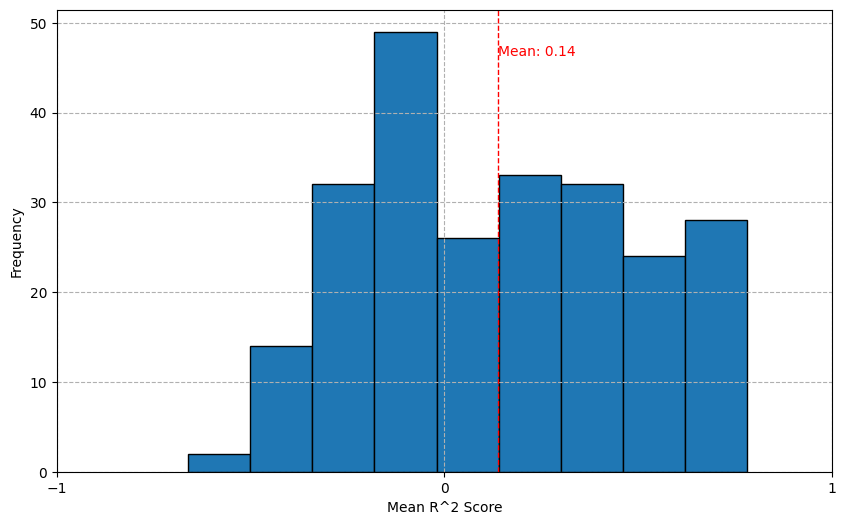

In [34]:
mean_score = np.mean(all_mean_scores)
plt.figure(figsize=(10, 6))
bin_edges = np.histogram_bin_edges(all_mean_scores, bins='auto')
bin_sizes = np.diff(bin_edges)  # Calculate the bin sizes
print("Bin sizes:", bin_sizes)
average_bin_size = np.mean(bin_sizes)
print("Average bin size:", average_bin_size)
plt.hist(all_mean_scores, bins=bin_edges, edgecolor='black')

# Set the x-axis label
plt.xlabel('Mean R^2 Score')

# Set the y-axis label
plt.ylabel('Frequency')

# Set x-axis ticks
xticks_major = np.arange(-1, max(all_mean_scores) + 1, 1)
plt.xticks(xticks_major)

# Draw a vertical line for the mean score
plt.axvline(mean_score, color='red', linestyle='dashed', linewidth=1)

# Annotate the mean score
plt.text(mean_score, plt.gca().get_ylim()[1]*0.9, f'Mean: {mean_score:.2f}', color = 'red')

# Add grid lines
plt.grid(True, which="both", ls="--")  # Grid for both major and minor ticks

# Display the plot
plt.show()


### Who are Good medium mediocre predictors with variance <0.25, 0.

Good Models:

Variance (< 0.25): 
    model is stable and performs consistently regardless of how the data is split. 
    Mean R2R2 Score (> 0.5): 
    0.5 generally suggests that the model explains more than half of the variance in the target variable, which is considered good performance depending on the complexity of the data.

mediocre performing Models:
    Variance (0.25 - 0.5): indicates moderate stability. The model's performance might fluctuate more than a "good" model across different folds, but is not excessively unstable.
    Mean R2R2 Score (0.25 - 0.5): An R2R2 score in this range suggests that the model has some predictive power, but room for improvement.

Poor Models:
    Variance (> 0.5):  model's performance is quite inconsistent across different data splits. This can be a sign of overfitting to specific subsets of the data or a lack of robustness in the model.
    Mean R2R2 Score (< 0.25):  below 0.25 indicates that the model explains a relatively small portion of the variance in the target variable. For many applications, this would be considered poor performance.

# GOOD AND STABLE PERFORMING MODELS

In [35]:
len(rfr_results.keys())

243

In [36]:
print(f"target\t score variance across 10 runs\t mean Score 10x\t predictive power")
for item, target_data in rfr_results.items():
    score_variance = np.var(target_data['all_fold_scores'])
    mean_score = target_data['mean_10x']

    # Good models
    if score_variance < 0.25 and mean_score > 0.5:
        print(f"{item}\t{score_variance}\t{mean_score}\t good")

    # Mediocre models
    elif 0.25 <= score_variance < 0.5 and 0.25 <= mean_score < 0.5:
        print(f"{item}\t{score_variance}\t{mean_score}\t mediocre")

    # poor models
    elif score_variance >= 0.5 or mean_score < 0.25:
        print(f"{item}\t{score_variance}\t{mean_score}\t poor")
    else:
        print(f"{item}\t{score_variance}\t{mean_score}\t stable_underperforming")



target	 score variance across 10 runs	 mean Score 10x	 predictive power
Cellobiose_361_204_rt14_40_nXcv	0.05310842545277473	0.5897269085803033	 good
tyrosine_218_280_rt10_78_nXcv	0.06213709283113654	0.11085437329313494	 poor
threonic_acid_292_220_rt7_49_nXcv	0.009525452731610594	0.7318115388637707	 good
isoleucin_158_233_rt_5_21_nXcv	0.1043465771091516	0.2121212925727157	 poor
asparagine_116_188_rt9_00_nXcv	0.05316078842495595	-0.22458430606075327	 poor
adenine_264_279_rt11_12_nXcv	0.06402819559258645	-0.2655481852980244	 poor
glycerol_117_205_rt4_75_nXcv	0.20099238042532425	-0.11837211297942517	 poor
raffinose_437_451_rt16_91_nXcv	0.02068233887210715	0.6529764438623658	 good
adenosine_5_monophosphate_169__nXcv	0.04242440894509291	0.39880888277050774	 stable_underperforming
ornithine_142_174_rt9_34_nXcv	0.07341561001679256	-0.30546309159731394	 poor
glucose_160_rt9_81_nXcv	0.1595782536023579	0.38459983399915115	 stable_underperforming
inositol_myo_305_265_rt10_71_nXcv	0.107894334816150